In [10]:
import numpy as np
import matplotlib.pyplot as plt
# for dark theme aficionados
plt.style.use('dark_background')
# parameters of the problem
l = 0 # spatial mode
R0 = 0.1 # input radius
DuctLength = 1
R = R0 + DuctLength
delta = 0.4 # pml width
R_PML = R + delta
r = np.linspace(R0, R_PML, 200) + 0*1j
Al = 1. # boundary condition at r=R0
k = 25 # wavenumber

In this example, we solve again the 1D spherical Helmholtz problem but terminate the domain by a Perfectly Matched Layer (PML). The global domain is split into
- the *physical domain*, $r \in [R_0,R]$
- the *PML domain*, $r \in [R,R_{pml}]$

The PML domain is termniated by a homogeneous Neumann boundary condition at $r=R_{pml}$

# Analytical solution with PML

Let us first extend the analytical solution in the PML thanks to the radial complex stretching, that is

$$ \tilde{u}_{\text{ex}}(r) = A_{\ell} h^{(1)}_{\ell} (k\tilde{r}), \quad \tilde{r} = r + \frac{F(\xi)}{\imath k}, \; \xi \in [0,1) $$

where $F$ is the PML stretching function. For the example let us use an unbounded stretching of the form $F(\xi) = \log(1-\xi)$

In [11]:
def F(xi):
	return np.log(1-xi)
def Fprime(xi):
	return -1/(1-xi)

xi = (r - R) / delta # linear mapping between \xi in [0,1] and r_pml in [R, R_pml]
r_tilde = np.piecewise(r, [r < R, r >= R], [lambda r: r, lambda r: r + F((r-R)/delta)/(1j*k)])

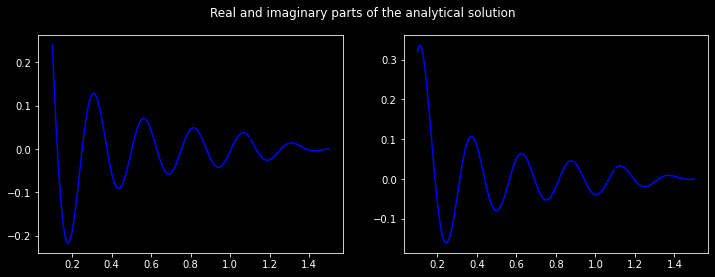

In [12]:
from AnalyticalSolutions import spherical_hankel
u_ex = Al*spherical_hankel(l,k*r_tilde)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle('Real and imaginary parts of the analytical solution')
ax1.plot(np.real(r), np.real(u_ex), 'b')
ax1.vlines(R, np.min(np.real(u_ex)), np.max(np.real(u_ex)), linestyles ="dashed", colors ="k")
ax2.plot(np.real(r), np.imag(u_ex), 'b')
ax2.vlines(R, np.min(np.imag(u_ex)), np.max(np.imag(u_ex)), linestyles ="dashed", colors ="k")


# Numerical resolution

For the weak formulation in the PML domain, we simply perform the complex change of variables, which leads to:

Find $u \in H^1(\Omega_{pml})$ such that:

$$ \forall v \in H^1(\Omega_{pml}), \quad \int_{R}^{R_{pml}} \left\{ \frac{1}{\gamma_r^2} \frac{d u}{d r} \overline{\frac{d v}{d r}} - \frac{1}{\gamma_r} \frac{2}{\tilde{r}}  \frac{d u}{d r} \overline{v} - \left(k^2 - \frac{\ell(\ell+1)}{\tilde{r}^2}\right) u \overline{v} \right\} \, \gamma_r \text{d}r  = 0$$

In order to implement the weak formulation, we need 

$\tilde{r} = r + \frac{F(\xi)}{\imath k}$ and $\gamma_r = \frac{d\tilde{r}}{dr} = 1 + \frac{F'(\xi)}{\imath \delta k}$

that is we only need to know $F(\xi)$ and $F'(\xi)$ for the normalized PML variable $\xi$. These quantities can be evaluated at the integration points when performing the numerical quadrature.

In [13]:
from ExternalFunctions import CreateDofs
from ExternalPmlFunctions import Mesh1D_PML
def initiate(DuctLength, NrOfElem, NrOfElemPML, Order, R0, delta):
    NrOfNodes, Coord, Element = Mesh1D_PML(DuctLength, NrOfElem, R0, R0+DuctLength, NrOfElemPML, delta)
    NrOfDofs, DofNode, DofElement = CreateDofs(NrOfNodes,NrOfElem+NrOfElemPML,Element,Order)
    return NrOfNodes, Coord, Element, NrOfDofs, DofNode, DofElement

In [14]:
def assemble_matrix(NrOfDofs,NrOfElem,Order,Coord,Element,DofElement, k, l, R):
    from ExternalPmlFunctions import MassAndStiffness_spherical_1D_PML
    Matrix = np.zeros((NrOfDofs,NrOfDofs), dtype=np.complex128)
    for iElem in np.arange(1,NrOfElem+1):
        # call the function returning the mass and stifness element matrices
        Ke, Ce, Me, Me_r2 = MassAndStiffness_spherical_1D_PML(iElem, Order, Coord, Element, F, Fprime, delta, R, k)
        ElemDofs = (DofElement[:,iElem-1]).astype(int)
        # assemble
        Matrix[np.ix_(ElemDofs,ElemDofs)] += Ke - 2*Ce - k**2*Me + (l*(l+1))*Me_r2
    return Matrix

In [15]:
def assemble_rhs(NrOfDofs,DofNode, k, l, R0, Al):
    from AnalyticalSolutions import d_spherical_hankel
    # and the velocity at first node
    Rhs = np.zeros((NrOfDofs,1), dtype=np.complex128)
    Rhs[DofNode[0]] = -Al*k*d_spherical_hankel(l,k*R0)
    return Rhs

def solve(Matrix, Rhs):
    # solve the sparse system of equations 
    Sol = np.linalg.solve(Matrix, Rhs) 
    return Sol

In [16]:
def compute_model(k, Order, NrOfElem, DuctLength, l, R0=0.1, NrOfElemPML=4):
    from ExternalFunctions import GetSolutionOnSubgrid
    h = DuctLength/NrOfElem # mesh size
    R = R0 + DuctLength
    d_lambda = 2*np.pi/(k*h)*Order # nr of dofs per wavelength
    # first create the mesh and the Dofs list
    NrOfNodes, Coord, Element, NrOfDofs, DofNode, DofElement = initiate(DuctLength, NrOfElem, NrOfElemPML, Order, R0, delta)
    # then assemble the matrix
    Matrix = assemble_matrix(NrOfDofs,NrOfElem+NrOfElemPML,Order,Coord,Element,DofElement, k, l, R)
    # assemble RHS
    Rhs = assemble_rhs(NrOfDofs,DofNode, k, l, R0, Al)
    # solve the sparse system of equations 
    Sol = solve(Matrix, Rhs)
    # compute the solution on a subgrid 
    Lambda = 2*np.pi/k; NrOfWavesOnDomain = DuctLength/Lambda
    x_sub_tot, u_h_sub_tilde = GetSolutionOnSubgrid(Sol, Order, Coord, Element, NrOfElem+NrOfElemPML, DofElement, NrOfWavesOnDomain)
    x_sub, u_h_sub = GetSolutionOnSubgrid(Sol, Order, Coord, Element, NrOfElem, DofElement, NrOfWavesOnDomain)
    # exact solution on subgrid 
    x_sub_tot = x_sub_tot+0*1j
    x_sub_tilde = np.piecewise(x_sub_tot, [x_sub_tot < R, x_sub_tot >= R], [lambda r: r, lambda r: r + F((r-R)/delta)/(1j*k)])
    u_exact_sub_tilde = Al*spherical_hankel(l,k*x_sub_tilde)
    u_exact_sub = Al*spherical_hankel(l,k*x_sub)
    return x_sub, x_sub_tot, u_h_sub, u_h_sub_tilde, u_exact_sub, u_exact_sub_tilde, NrOfDofs, d_lambda, Sol, Coord, Element

In [17]:
def plot_result(x_sub, u_h_sub, u_exact_sub, NrOfDofs, d_lambda, NrOfElem, Coord, Element, Order):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4), tight_layout=True)
    ax.plot(np.real(x_sub), np.real(u_h_sub), label="$Re(u_h)$",linewidth=2)
    ax.plot(np.real(x_sub), np.real(u_exact_sub), label="$Re(u_{exact})$",linewidth=2) 
    ax.legend(loc="best",fontsize=16)
    ax.set(xlabel=r'$x$', ylabel=r'real part',
           title='NrOfDofs = '+str(NrOfDofs) + ', ($d_\lambda$=%1.4g' %d_lambda +' Dofs per wavelength)')
    plt.show()

def compute_interactive(k, Order, NrOfElem, DuctLength, l):
    x_sub, x_sub_tot, u_h_sub, u_h_sub_tilde, u_exact_sub, u_exact_sub_tilde, NrOfDofs, d_lambda, Sol, Coord, Element = compute_model(k, Order, NrOfElem, DuctLength, l, R0, 4)
    plot_result(x_sub_tot, u_h_sub_tilde, u_exact_sub_tilde, NrOfDofs, d_lambda, NrOfElem, Coord, Element, Order)
    E2 = np.linalg.norm(u_h_sub - u_exact_sub)/np.linalg.norm(u_exact_sub)*100
    print('-' *100 +'\n'+' Physical domain: Numerical error is %1.4g' %E2 + ' % \n' +'-' *100)
    E2_tot = np.linalg.norm(u_h_sub_tilde - u_exact_sub_tilde)/np.linalg.norm(u_exact_sub_tilde)*100
    print('-' *100 +'\n'+' Global domain: Numerical error is %1.4g' %E2_tot + ' % \n' +'-' *100)

In [18]:
from ipywidgets import interactive
import ipywidgets as widgets
interactive_plot = interactive(compute_interactive, k=widgets.IntSlider(value=6, min=1, max=50, description='Frequency'),
                               Order=widgets.IntSlider(value=3, min=1, max=8, description='Order'),
                               NrOfElem=widgets.IntSlider(value=20, min=1, max=200, description='Nb of Elts'),
                               DuctLength=widgets.IntSlider(value=1, min=1, max=5, description='Duct length'),
							   l=widgets.IntSlider(value=0, min=0, max=20, description='Harmonic'))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=6, description='Frequency', max=50, min=1), IntSlider(value=3, descripti…